In [88]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from keras import utils as np_utils


from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

import re

from nltk.corpus import stopwords
from nltk import word_tokenize



In [42]:
STOPWORDS = set(stopwords.words('english'))

## Chargement des données

In [43]:
df=pd.read_csv("289df373-42e6-40fe-a3ab-8c8110f0a571.csv")
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [44]:
df.shape

(2225, 2)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [46]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [55]:
from statistics import mean

def vect_len(df1):
    return [len(text1) for text1 in df1.text]

def mean_len(df1):
    return mean([len(text1) for text1 in df1.text])

In [48]:
mean_len(df)

2262.936179775281

## Prétraitement / nettoyage

In [49]:
space = re.compile('[/(){}\[\]\|@,;]')
symbols= re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = space.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = symbols.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [51]:
df_clean=df.copy()
df_clean['text']=df['text'].apply(clean_text)

In [52]:
mean_len(df_clean)

1569.8224719101124

Text(0, 0.5, 'After clean')

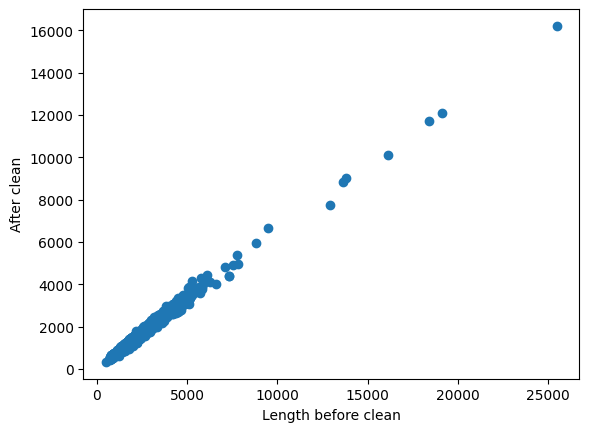

In [58]:
plt.scatter(vect_len(df), vect_len(df_clean))
plt.xlabel('Length before clean')
plt.ylabel('After clean')

On a bien réduit la taille moyenne des texte

In [ ]:
df['text'][7]

'henman hopes ended dubai third seed tim henman slumped straight sets defeat raininterrupted dubai open quarterfinal ivan ljubicic croatian eighth seed booked place last four 75 64 victory british number one henman looked course level match going 20 second set progress halted rain intervened ljubicic hit back break seal fourth straight win henman earlier day spanish fifth seed tommy robredo secured semifinal place beat nicolas kiefer germany 64 64 afterwards henman left cursing weather umpire seven breaks rain match incredibly frustrating henman said raining umpire take control kept telling us play till end game raining come score irrelevant frustrating happy form epect desert'

Exemple de Stopwords enlevés

## Tokenization

In [60]:
tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 29726 unique tokens.


## Encodage de la cible et préparation des jeux de données

In [85]:
le = LabelEncoder()
y = le.fit_transform(df_clean['category'])
le.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [89]:
Y = np_utils.to_categorical(y, num_classes= 5)

In [64]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=1200)

In [90]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2002, 1200) (2002, 5)
(223, 1200) (223, 5)


## Construction du modèle

In [91]:
model=Sequential()
model.add(Embedding(50000,100,input_length=1200))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1200, 100)         5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1200, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________


In [93]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=128,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
15/15 [==============================] - 150s 10s/step - loss: 1.5919 - accuracy: 0.2482 - val_loss: 1.5715 - val_accuracy: 0.2935
Epoch 2/10
15/15 [==============================] - 142s 9s/step - loss: 1.5612 - accuracy: 0.4242 - val_loss: 1.5210 - val_accuracy: 0.4428
Epoch 3/10
15/15 [==============================] - 144s 10s/step - loss: 1.4375 - accuracy: 0.5297 - val_loss: 1.3634 - val_accuracy: 0.5224
Epoch 4/10
15/15 [==============================] - 152s 10s/step - loss: 1.2460 - accuracy: 0.7646 - val_loss: 1.0957 - val_accuracy: 0.6070
Epoch 5/10
15/15 [==============================] - 144s 10s/step - loss: 0.8618 - accuracy: 0.6746 - val_loss: 0.7874 - val_accuracy: 0.6318
Epoch 6/10
15/15 [==============================] - 168s 11s/step - loss: 0.6791 - accuracy: 0.6885 - val_loss: 0.7425 - val_accuracy: 0.6816
Epoch 7/10
15/15 [==============================] - 156s 10s/step - loss: 0.5262 - accuracy: 0.8195 - val_loss: 0.5540 - val_accuracy: 0.7711
Epoch 8